# VAE Model Testing Framework

In [ ]:
import sys
from pathlib import Path

# Find project root by looking for .git or requirements.txt
current = Path.cwd()
while not any((current / marker).exists() for marker in ['.git', 'requirements.txt']):
    if current.parent == current:
        raise FileNotFoundError("Project root not found")
    current = current.parent

sys.path.append(str(current))
print(f"Added project root: {current}")

Added project root: /notebooks


# Hyperparemeters

In [ ]:
import torch

#### deterministic run ####
determinism_kwargs = {
    'seed':0,
    'use_cuda_det': True,
    'enforce_det':False,
    'cublas_workspace_config': None,
}
##### Model parameters #####
model_name = 'vae_locatello'  # Name of the model architecture file (e.g., 'vae_burgess')
model_decoder_output_dist = 'bernoulli'  # Output distribution of the decoder (e.g., 'bernoulli', 'gaussian')
latent_dim = 10
use_torch_compile = False  # Use torch.compile for model compilation (requires PyTorch 2.0 or higher)

#### Training parameters ####
train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 1

# train_step_unit = 'iteration'  # Unit for training steps ('epoch' or 'iteration')
# num_train_steps = int(9e3)  # Number of training steps 

learning_rate = 1e-4
batch_size = 64

#### losses ####
loss_name = 'betavae'      # Type of loss ('betavae', 'annealedvae', 'betatcvae')
loss_kwargs = {
    'beta': 16,
    'rec_dist': 'gaussian',  # Reconstruction distribution ('bernoulli', 'gaussian')
    'log_kl_components':True
               }

#### device parameters ####
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU")
else:
    print("Using CPU")

### Checkpoint parameters ###
return_chkpt = False
chkpt_every_n_steps=2400

# chkpt_save_path = 'checkpoints/tests/test-epoch-1.pt'
chkpt_save_path = None

chkpt_save_dir = None
# chkpt_save_dir = 'checkpoints/tests_1'

chkpt_save_master_dir=None
# chkpt_viz = True

Using GPU


# Reproducibility

In [3]:
if determinism_kwargs is not None:
    # MUST Be set before importing any other modules
    # to ensure reproducibility across all libraries
    from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader
    set_deterministic_run(**determinism_kwargs)
    print(f"Set deterministic run with kwargs: {determinism_kwargs}")

Set deterministic run with kwargs: {'seed': 0, 'use_cuda_det': True, 'enforce_det': False, 'cublas_workspace_config': None}


# Imports

In [4]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

# Shapes3d

## Load dataset

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)

# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

if determinism_kwargs is not None:
    shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset, 
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    shapes3d_dataloader = torch.utils.data.DataLoader(shapes3d_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_3dshapes, 
                                                      shuffle=True, 
                                                      pin_memory=True)


print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")


Loaded 3D Shapes dataset with 480000 samples.


## Setup Model, Loss, and Optimizer

In [ ]:
def setup_components(dataset, loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)
    

    # Instantiate Model
    model = vae_models.select(name=model_name, 
                              img_size=img_size, 
                              latent_dim=latent_dim, 
                              decoder_output_dist=model_decoder_output_dist
                              ).to(device)

    if loss_name == 'betatcvae':
        loss_kwargs['n_data'] = n_data
    
    loss_fn = losses.select(loss_name, **loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.model_name}")
    print(f"Loss: {loss_fn.name} (rec_dist={loss_kwargs['rec_dist']}), kwargs={loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## Train

In [ ]:
shapes3d_loss_kwargs = loss_kwargs.copy()
shapes3d_loss_kwargs.update({'beta': 16})

In [8]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                                      loss=loss_fn_3dshapes,
                                      optimizer=optimizer_3dshapes,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_logs=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      chkpt_save_dir=chkpt_save_dir,
                                      chkpt_every_n_steps=chkpt_every_n_steps,
                                      chkpt_viz=chkpt_viz
                                      )

trainer_3dshapes.train(step_unit=train_step_unit, max_steps=num_train_steps, dataloader=shapes3d_dataloader)


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: vae_locatello
Loss: betavae (rec_dist=gaussian), kwargs={'beta': 16, 'rec_dist': 'gaussian', 'log_kl_components': True}
Optimizer: Adam
---------------------------


Training for 7500 iter, 1.00 epochs:  32%|███▏      | 2397/7500 [00:15<00:26, 194.38it/s, epoch=0.32/1.00, iter=2400/7500, kl_loss=9.41, kl_loss_0=0.0405, kl_loss_1=1.69, kl_loss_2=1.35, kl_loss_3=1.47, kl_loss_4=0.0645, kl_loss_5=1.41, kl_loss_6=0.0344, kl_loss_7=1.5, kl_loss_8=1.75, kl_loss_9=0.0917, loss=399, rec_loss=248]                               

Creating and saving checkpoint at checkpoints/tests_1/chkpt_1/chkpt_1.pth at iteration 2400


Training for 7500 iter, 1.00 epochs:  64%|██████▍   | 4790/7500 [00:34<00:15, 175.43it/s, epoch=0.64/1.00, iter=4800/7500, kl_loss=9.77, kl_loss_0=0.0381, kl_loss_1=1.77, kl_loss_2=1.4, kl_loss_3=1.48, kl_loss_4=0.124, kl_loss_5=1.45, kl_loss_6=0.04, kl_loss_7=1.55, kl_loss_8=1.74, kl_loss_9=0.188, loss=359, rec_loss=203]    

Creating and saving checkpoint at checkpoints/tests_1/chkpt_2/chkpt_2.pth at iteration 4800


Training for 7500 iter, 1.00 epochs:  96%|█████████▌| 7191/7500 [00:51<00:01, 196.91it/s, epoch=0.96/1.00, iter=7200/7500, kl_loss=10, kl_loss_0=0.03, kl_loss_1=1.76, kl_loss_2=1.45, kl_loss_3=1.53, kl_loss_4=0.123, kl_loss_5=1.47, kl_loss_6=0.0438, kl_loss_7=1.58, kl_loss_8=1.74, kl_loss_9=0.309, loss=341, rec_loss=181]    

Creating and saving checkpoint at checkpoints/tests_1/chkpt_3/chkpt_3.pth at iteration 7200


Training for 7500 iter, 1.00 epochs: 100%|█████████▉| 7479/7500 [00:56<00:00, 175.96it/s, epoch=1.00/1.00, iter=7500/7500, kl_loss=10, kl_loss_0=0.0271, kl_loss_1=1.77, kl_loss_2=1.45, kl_loss_3=1.52, kl_loss_4=0.121, kl_loss_5=1.45, kl_loss_6=0.0454, kl_loss_7=1.54, kl_loss_8=1.75, kl_loss_9=0.347, loss=337, rec_loss=177] 

Creating and saving checkpoint at checkpoints/tests_1/chkpt_4/chkpt_4.pth at iteration 7500


{'logs': {'train_losses_log': [{'loss': 1700.9673791503906,
    'rec_loss': 1698.1490899658204,
    'kl_loss': 0.17614290852099657,
    'kl_loss_0': 0.01968884836882353,
    'kl_loss_1': 0.014443990183062852,
    'kl_loss_2': 0.023195226844400167,
    'kl_loss_3': 0.015036357745993883,
    'kl_loss_4': 0.016282279854640366,
    'kl_loss_5': 0.01725930684711784,
    'kl_loss_6': 0.01393447668524459,
    'kl_loss_7': 0.018066423193085938,
    'kl_loss_8': 0.01947542678564787,
    'kl_loss_9': 0.018760571100283414,
    'iter': 200,
    'epoch': 0.02666666666666667},
   {'loss': 1529.9993939208985,
    'rec_loss': 1528.207576904297,
    'kl_loss': 0.11198866175487637,
    'kl_loss_0': 0.014522448838688433,
    'kl_loss_1': 0.006994565953500569,
    'kl_loss_2': 0.018559690262191,
    'kl_loss_3': 0.006991295355837792,
    'kl_loss_4': 0.009086287969257683,
    'kl_loss_5': 0.0087951132748276,
    'kl_loss_6': 0.006859964779578149,
    'kl_loss_7': 0.008521333516109736,
    'kl_loss_8': 0.0

### Visualization

In [9]:
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

#### Reconstructions

Plotting random reconstructions...


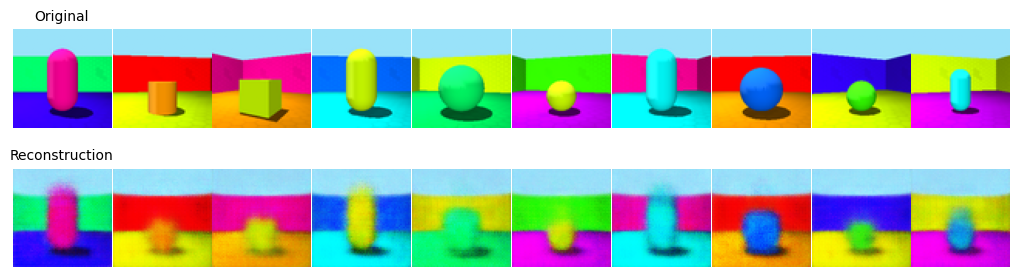

Plotting reconstructions from specific indices...


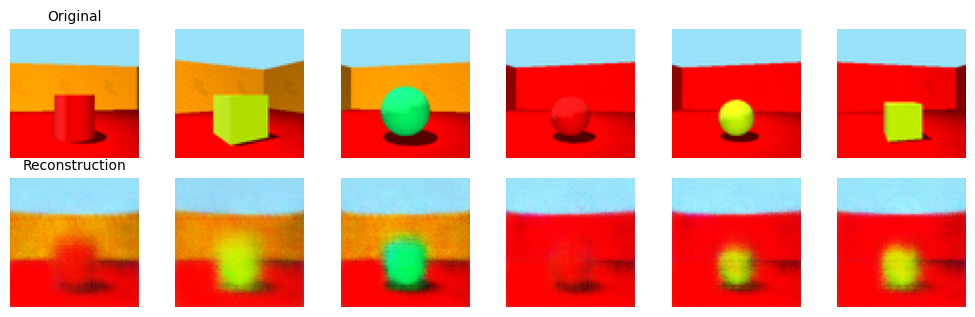

In [10]:
print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

#### Latent traversal

Plotting latent traversals...


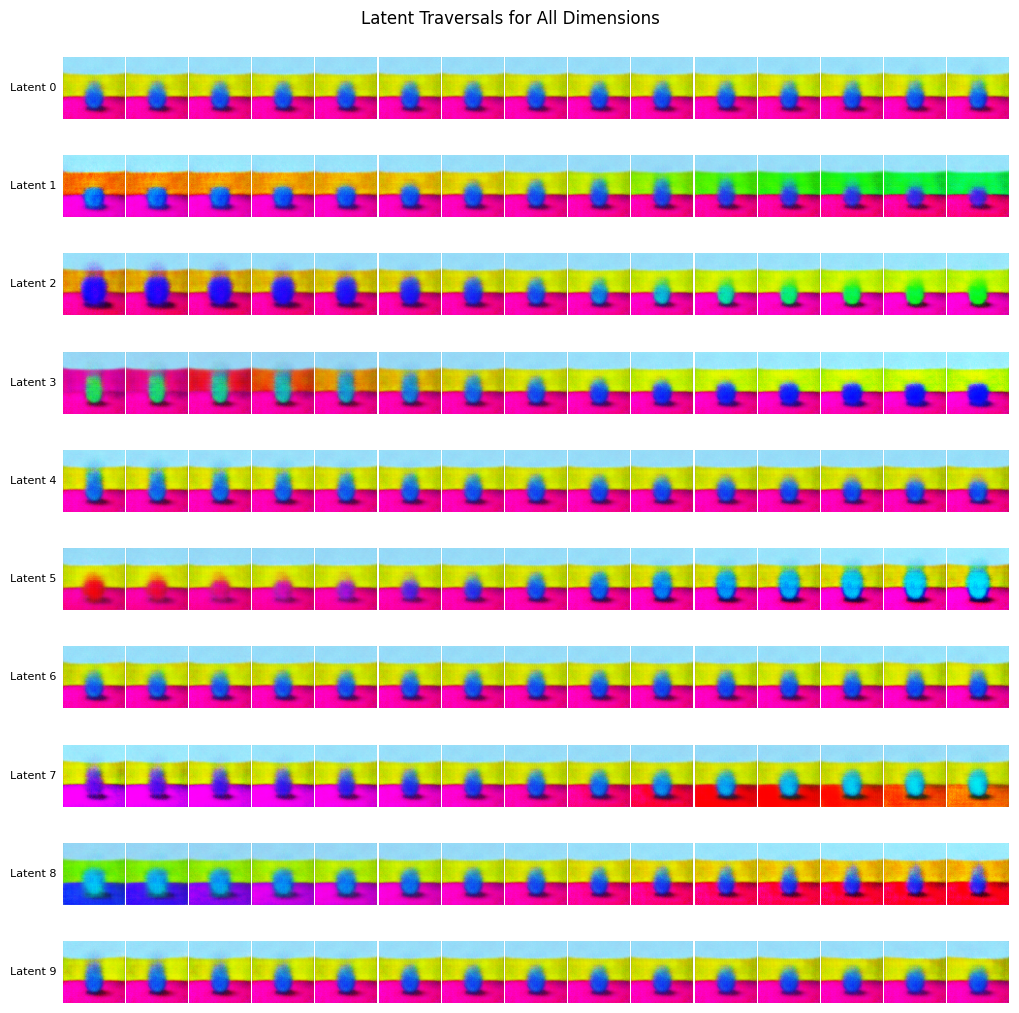

In [18]:
print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=15)
plt.show()

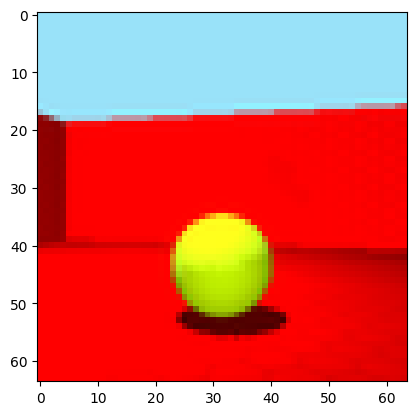

In [17]:
ref_img_idx = 1000
ref_img = shapes3d_dataset[ref_img_idx][0]
plt.imshow(ref_img.permute(1, 2, 0).cpu().numpy())

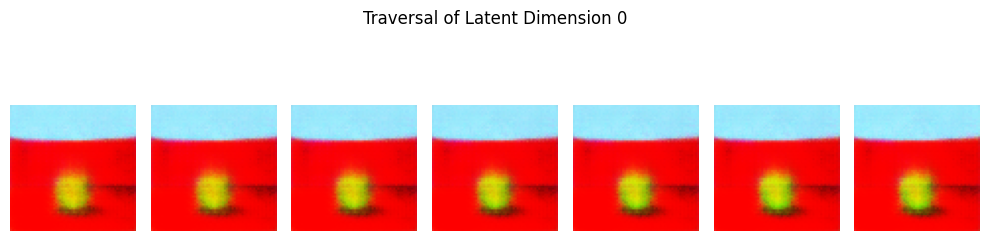

In [16]:
# single latent traversal based on the reference image
latent_idx = 0  # Index of the latent dimension to traverse
visualizer_3dshapes.plot_single_latent_traversal(latent_idx, 
                                                 ref_img=ref_img, 
                                                 num_samples=7,
                                                 max_traversal_type='absolute', 
                                                 max_traversal=2)

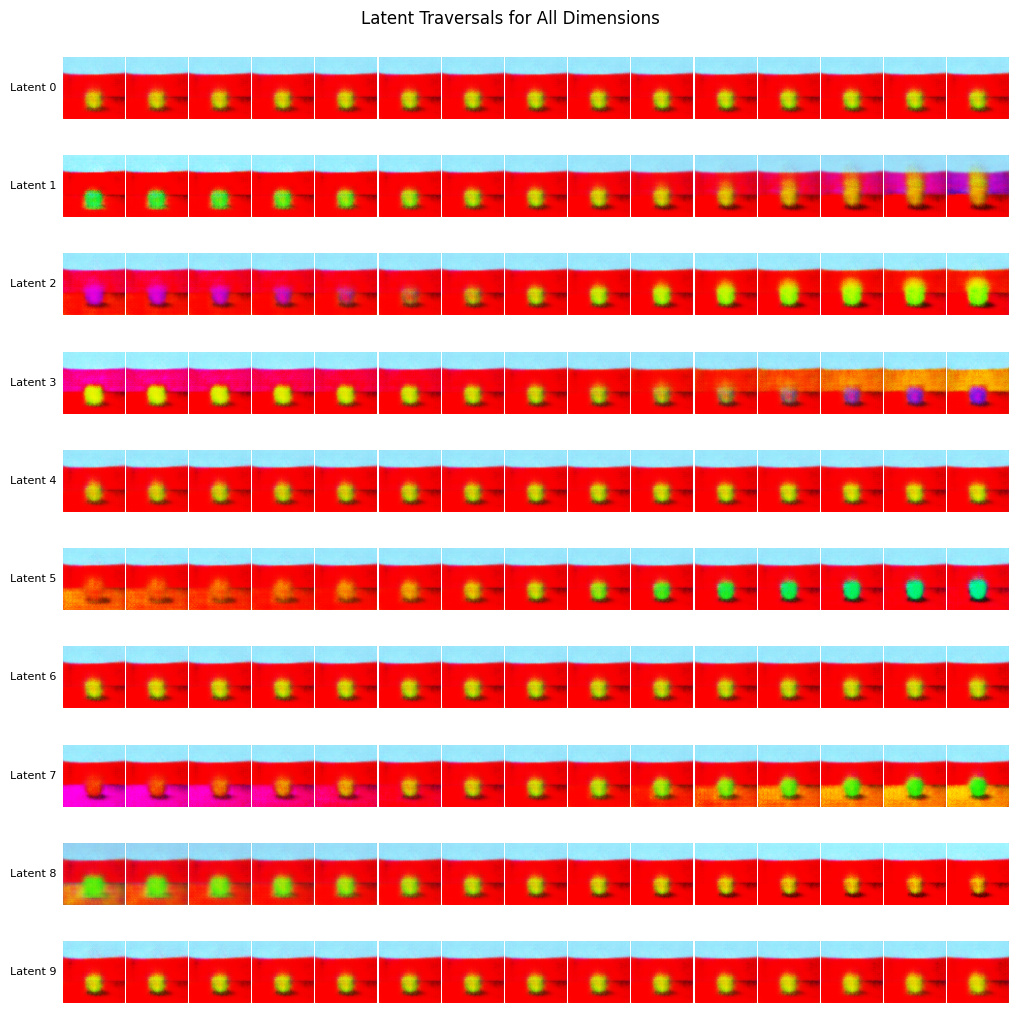

In [15]:
visualizer_3dshapes.plot_all_latent_traversals(ref_img=ref_img, 
                                               num_samples=15,  
                                               max_traversal_type='probability',
                                               max_traversal=0.95,
                                               use_ref_img_lat_std=False
                                               )

## Metric Evaluation

In [15]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}}, # Added num_train and num_test
    {'name': 'mig', 'args':{}} # MIG uses default args (num_bins=20, num_workers=8, etc.)
]

metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes, 
                                                              data_loader=shapes3d_dataloader, 
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:27<00:00, 271.30it/s]


3D Shapes Metrics: {'dci_d': {'disentanglement': 0.3040762895451541, 'completeness': 0.2524660614475031, 'informativeness_train_scores': 0.8665666666666666, 'informativeness_test_scores': 0.6713333333333332, 'informativeness_train_errors': 0.13343333333333332, 'informativeness_test_errors': 0.32866666666666666}, 'mig': 0.022839030207748943}


# dSprites

In [16]:
# Load dSprites
Dsprites = get_dataset('dsprites')

dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

if determinism_kwargs is not None:
    dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=determinism_kwargs['seed'],
                                                   pin_memory=True)
else:
    dsprites_dataloader = torch.utils.data.DataLoader(dsprites_dataset, 
                                                      batch_size=batch_size, 
                                                      num_workers=num_workers_dsprites, 
                                                      shuffle=True, 
                                                      pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## Train

In [17]:
# Beta VAE
loss_kwargs_beta_vae_dsprites =  {
    'beta': 16,
    'rec_dist': 'bernoulli', # Use the globally defined rec_dist
    'log_kl_components':True
               }

In [ ]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, loss_kwargs_beta_vae_dsprites)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                                      loss=loss_fn_dsprites,
                                      optimizer=optimizer_dsprites,
                                      lr_scheduler=None,
                                      determinism_kwargs=determinism_kwargs,
                                      use_torch_compile=use_torch_compile,
                                      return_log_loss=True,
                                      return_chkpt=return_chkpt,
                                      chkpt_save_path=chkpt_save_path,
                                      )
trainer_dsprites.train(max_steps=num_train_steps, step_unit=train_step_unit, dataloader=dsprites_dataloader)


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: vae_locatello
Loss: betavae (rec_dist=bernoulli), kwargs={'beta': 16, 'rec_dist': 'bernoulli', 'log_kl_components': True}
Optimizer: Adam
---------------------------


Training for 11520 iter, 1.00 epochs:  98%|█████████▊| 11248/11520 [01:26<00:02, 131.40it/s, epoch=0.98/1.00, iter=11250/11520, kl_loss=6.53, kl_loss_0=1.41, kl_loss_1=0.00598, kl_loss_2=1.15, kl_loss_3=0.00731, kl_loss_4=1.61, kl_loss_5=0.487, kl_loss_6=0.00637, kl_loss_7=0.653, kl_loss_8=1.17, kl_loss_9=0.0236, loss=244, rec_loss=139]          

KeyboardInterrupt: 

In [ ]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)


===== Visualizing dSprites Results =====


## Visualization

### Reconstructions

Plotting random reconstructions...


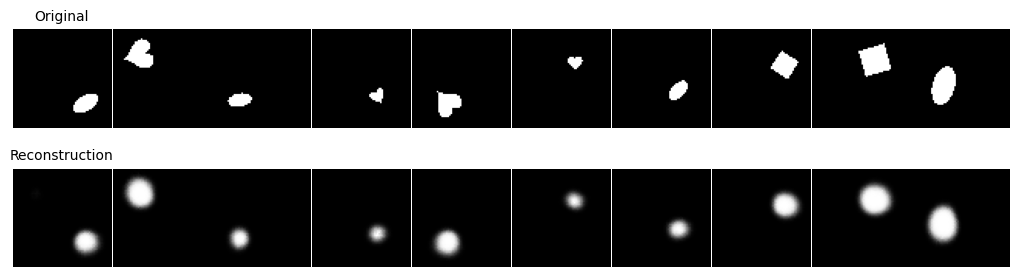

Plotting reconstructions from specific indices...


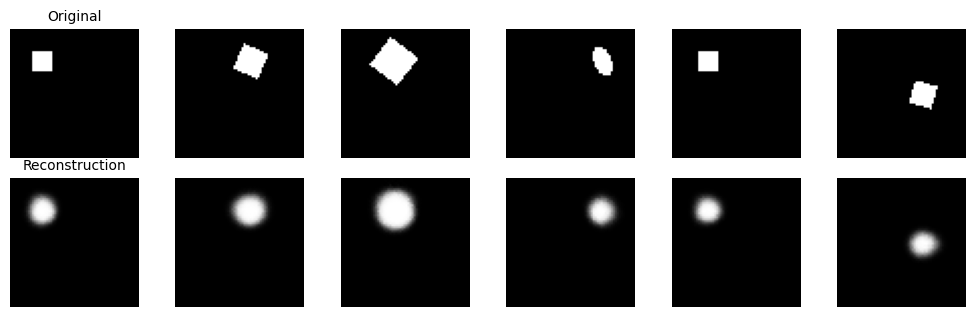

In [ ]:
print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

### Latent traversal

Plotting latent traversals...


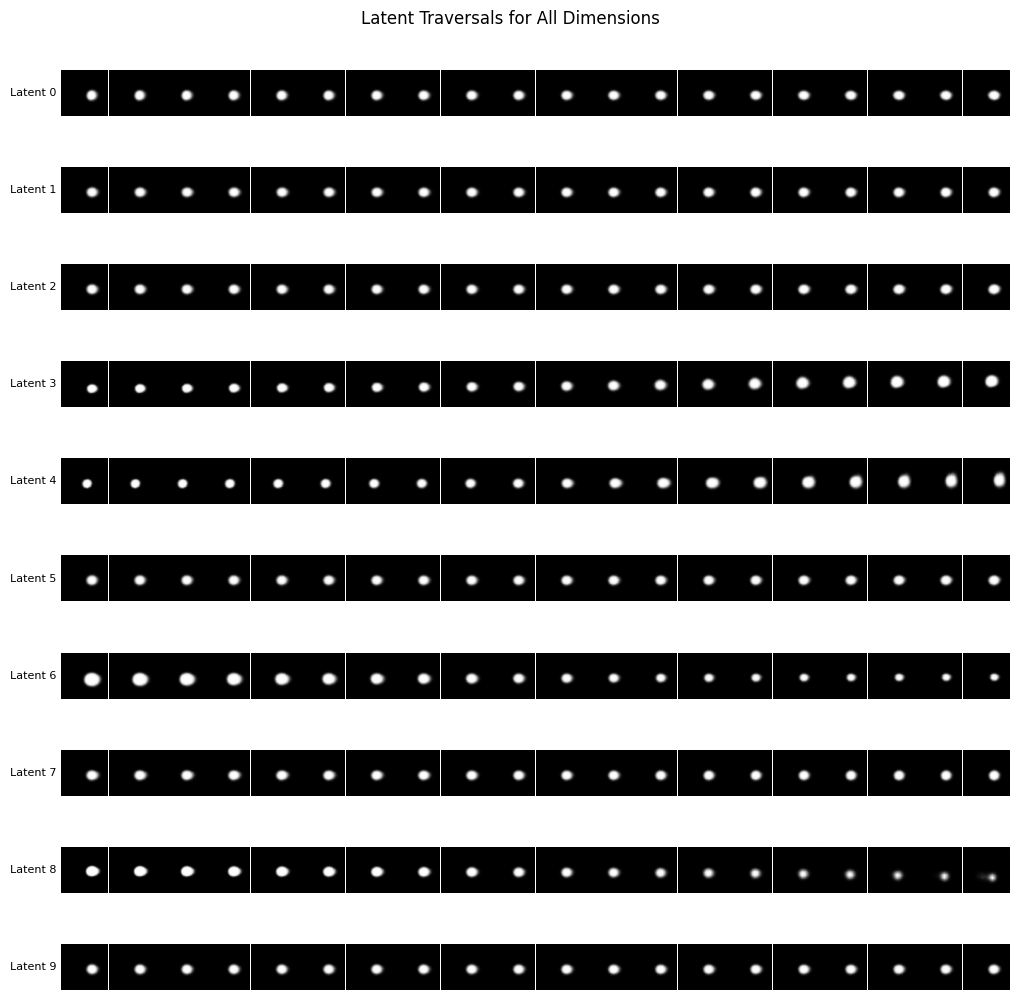

In [ ]:
print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

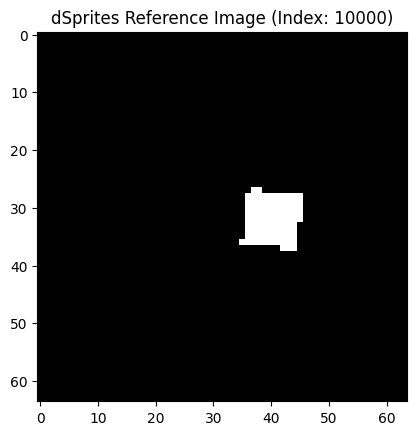

In [ ]:
# Select a reference image index for dSprites
ref_img_idx_dsprites = 10000  # Example index
ref_img_dsprites = dsprites_dataset[ref_img_idx_dsprites][0]

# Plot the reference image
plt.imshow(ref_img_dsprites.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.title(f"dSprites Reference Image (Index: {ref_img_idx_dsprites})")
plt.show()


Plotting single latent traversal for dimension 0...


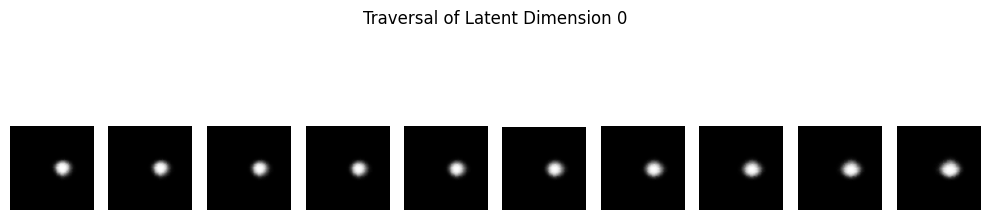

In [ ]:
# Single latent traversal based on the reference image
latent_idx_dsprites = 0  # Index of the latent dimension to traverse
print(f"Plotting single latent traversal for dimension {latent_idx_dsprites}...")
visualizer_dsprites.plot_single_latent_traversal(latent_idx_dsprites, ref_img=ref_img_dsprites, num_samples=10)
plt.show()

Plotting all latent traversals based on reference image...


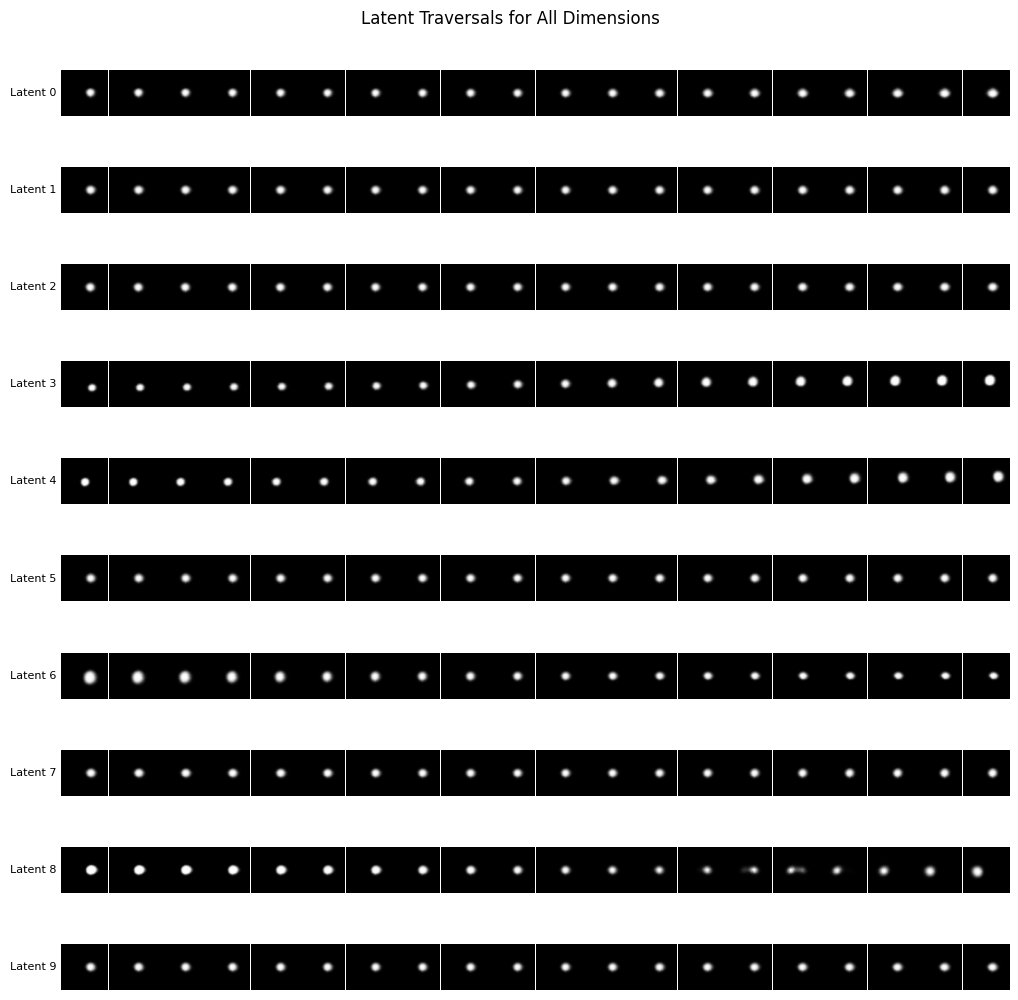

In [ ]:
# All latent traversals based on the reference image
print("Plotting all latent traversals based on reference image...")
visualizer_dsprites.plot_all_latent_traversals(ref_img=ref_img_dsprites, num_samples=20)
plt.show()

## Metric Evaluation (dSprites)

In [ ]:
print("\n===== Computing Metrics for dSprites =====")
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites, 
                                                            data_loader=dsprites_dataloader, 
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:21<00:00, 544.08it/s]


dSprites Metrics: {'dci_d': {'disentanglement': 0.04806127219267424, 'completeness': 0.06966468014544981, 'informativeness_train_scores': 0.83532, 'informativeness_test_scores': 0.3436, 'informativeness_train_errors': 0.16468000000000002, 'informativeness_test_errors': 0.6564}, 'mig': 0.04420432315348423}
